# Statescope Advanced tutorial

In this notebook, we will demonstrate the functionality of the Statescope framework for advanced users:
- Create a custom signature from scRNAseq data
- Use prior expectations for tumor cell fractions, both in single mode (simple model) and group-mode (detailed model, split into Basal/Classical)
- Perform Downstream analysis and interpretation in PDAC application, including retrieval of states in single cell profiles (StateRetrieval)

We will perform deconvolution, refinement and state discovery on the TCGA-PAAD bulk transcriptome dataset of PDAC samples using a custom scRNAseq signature

In [1]:
# Import libraries: All libraries (dependencies) used in this notebook are accompanied with Statescope (installation with pip install Statescope)
import Statescope.Statescope as scope
import pandas as pd
import anndata
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [31]:
# Read TCGA-PAAD dataset, stored locally and retrieved from https://portal.gdc.cancer.gov/projects/TCGA-PAAD
Bulk = pd.read_csv('TCGA_PAAD_Count_Matrix.txt', sep = '\t', index_col = 'gene')
Bulk.head(3)

,TCGA-IB-A6UG,TCGA-3A-A9IU,TCGA-FB-A545,TCGA-IB-AAUQ,TCGA-HV-A5A3,TCGA-IB-7897,TCGA-HV-AA8V,TCGA-HV-A5A5,TCGA-HZ-8638,TCGA-F2-7276,...,TCGA-2J-AAB9,TCGA-IB-AAUT,TCGA-OE-A75W,TCGA-2J-AAB4,TCGA-IB-7652,TCGA-3A-A9I9,TCGA-XN-A8T3,TCGA-IB-7649,TCGA-2J-AAB8,TCGA-3A-A9IB
gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,2684,3654,880,1090,1361,1692,1918,1882,3965,3384,...,1007,1754,1426,2037,2471,1714,2686,2018,682,2856
TNMD,0,1,0,4,0,119,1,0,4,12,...,0,1,3,0,2,11,3,2,5,2
DPM1,1139,1620,941,974,1148,1624,1130,1083,2317,1860,...,686,892,1333,1284,2374,1365,1123,796,737,1507


We will use a prior for the Tumor cell fractions to increase deconvolution performance.
For the purpose of this notebook we will use ABSOLUTE (DNA-based) tumor purities generated by the TCGA (Raphael et al, 2017) and stored locally (source: https://ars.els-cdn.com/content/image/1-s2.0-S1535610817302994-mmc2.xlsx).

In [32]:
# Read ABSOLUTE DNA-based purity estimates
Tumor_purities = pd.read_csv('ABSOLUTE_Purities.txt', sep = '\t', index_col = 'Tumor Sample ID')
Tumor_purities.index = ['-'.join(x.split('-')[0:3]) for x in Tumor_purities.index]
# subset and match Bulk to samples with purity information available 
Bulk = Bulk[Tumor_purities.index]
print(Tumor_purities)

              ABSOLUTE Purity
TCGA-2J-AAB1             0.38
TCGA-2J-AAB4             0.30
TCGA-2J-AAB6             0.54
TCGA-2J-AAB8             0.27
TCGA-2J-AABA             0.34
...                       ...
TCGA-XN-A8T5             0.09
TCGA-YB-A89D             0.24
TCGA-YH-A8SY             0.22
TCGA-YY-A8LH             0.55
TCGA-Z5-AAPL             0.10

[149 rows x 1 columns]


### Read and visualize scRNAseq dataset and annotations
For this tutorial we will use phenotyped scRNAseq data to use as a signature

In [2]:
# Read publicly available, phenotyped scRNAseq dataset from Werba et al
# We have classified Tumor cells into Classical and Basal cells based on the methods from Raghavan et al
scRNAseq_dataset = anndata.read_h5ad('adata_werba.h5ad')
scRNAseq_dataset

AnnData object with n_obs × n_vars = 139446 × 2257
    obs: 'major_celltype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'subtype', 'classical', 'basal', 'intermediate', 'batch'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'neighbors', 'pca', 'subtype_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
# The annotations for the simple model are stored in the major_celltype column and the annotations for the detailed model are stored in the 'subtype' column
print('Simple model celltypes:',scRNAseq_dataset.obs.major_celltype.unique())
print('\nDetailed model celltypes:',scRNAseq_dataset.obs.subtype.unique())
scRNAseq_dataset.obs

Simple model celltypes: ['Epithelial', 'T/NK', 'Endothelial', 'Myeloid', 'B/Plasma', 'CAFs', 'Mast']
Categories (7, object): ['B/Plasma', 'CAFs', 'Endothelial', 'Epithelial', 'Mast', 'Myeloid', 'T/NK']

Detailed model celltypes: ['Classical', 'Basal', 'Intermediate', 'T/NK', 'Endothelial', 'Myeloid', 'B/Plasma', 'CAFs', 'Mast']
Categories (10, object): ['B/Plasma', 'Basal', 'CAFs', 'Classical', ..., 'Intermediate', 'Mast', 'Myeloid', 'T/NK']


,major_celltype,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,subtype,classical,basal,intermediate,batch
0171-8-13-20-T:AAACCCACAACCCTAA-0,Epithelial,4702,15284.941406,709.361206,4.640915,Classical,1.070657,0.194597,0.098124,0
0171-8-13-20-T:AAACCCAGTCAAACGG-0,Epithelial,6491,27863.234375,1293.115356,4.640938,Classical,1.050891,0.209696,0.282326,0
0171-8-13-20-T:AAACGAAAGCAAATGT-0,Epithelial,6239,30390.886719,3224.069336,10.608671,Classical,0.674433,0.264121,0.082265,0
0171-8-13-20-T:AAACGAATCTGTCGCT-0,Epithelial,3451,11408.622070,105.957329,0.928748,Classical,0.586770,0.301722,0.235741,0
0171-8-13-20-T:AAACGCTCATGACAGG-0,Epithelial,1247,1984.657104,2.507676,0.126353,Classical,0.660913,0.284064,0.631576,0
...,...,...,...,...,...,...,...,...,...,...
Nov-6115-d0:TTTGCGCTCCCATTTA-1,Myeloid,1659,3623.447021,43.631046,1.204131,Myeloid,NaN,NaN,NaN,1
Nov-6115-d0:TTTGGTTTCCCTTGCA-1,Myeloid,2791,9542.416016,48.275646,0.505906,Myeloid,NaN,NaN,NaN,1
Nov-6115-d0:TTTGGTTTCTCAAACG-1,B/Plasma,2121,14648.389648,122.252419,0.834579,B/Plasma,NaN,NaN,NaN,1
Nov-6115-d0:TTTGTCAAGAGACTAT-1,B/Plasma,873,1576.427856,23.212360,1.472466,B/Plasma,NaN,NaN,NaN,1


/tmp/jjansen4.11750494/ipykernel_3646397/638166957.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


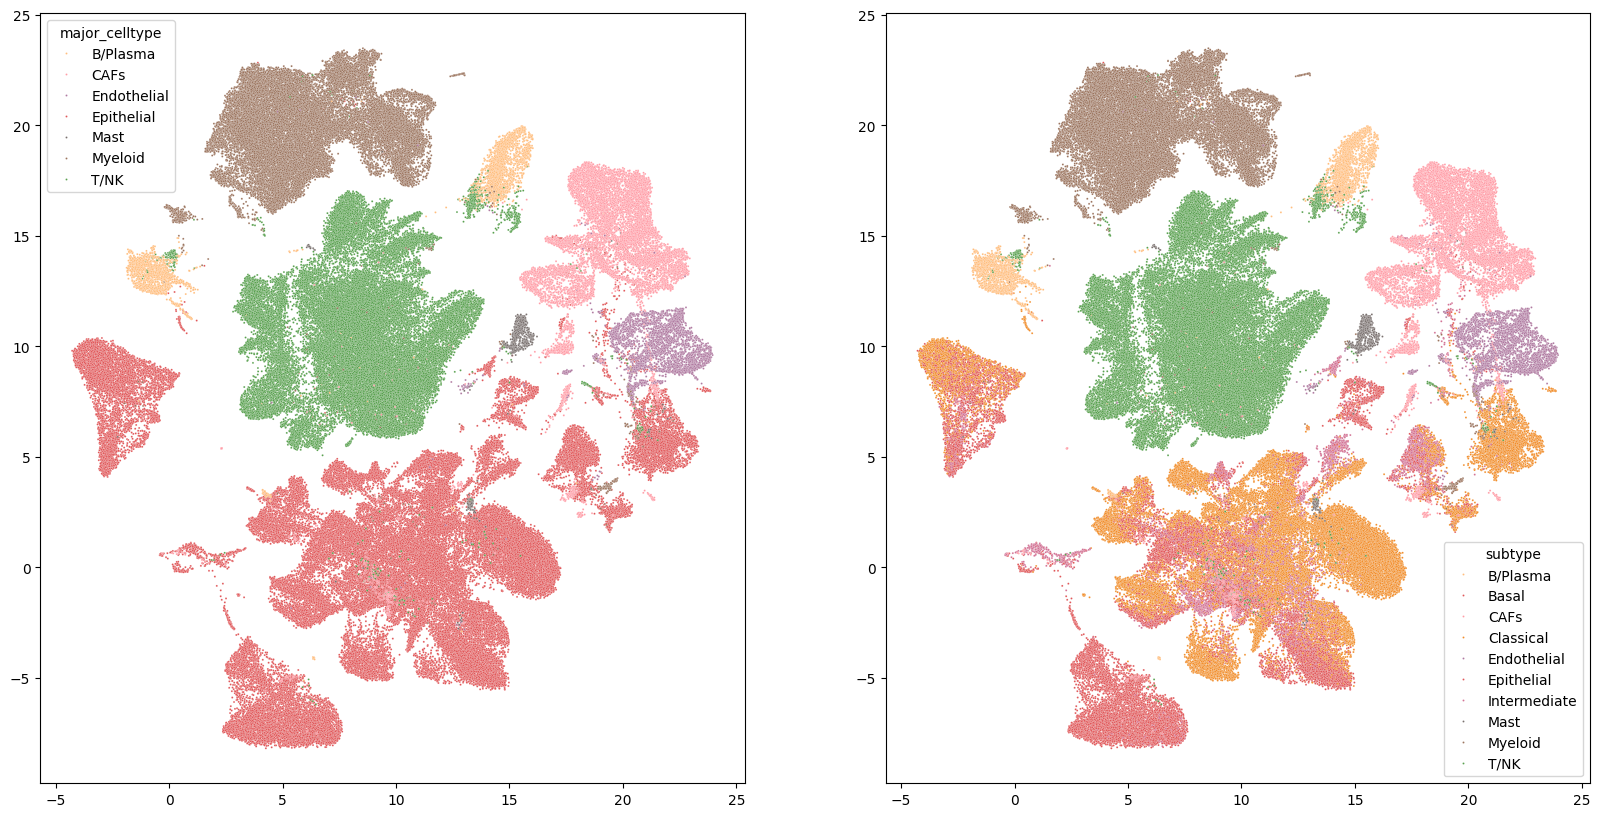

In [6]:
# Visualize annotated UMAP used to create a signature
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
color_pal = {'B/Plasma':'#FFBE7D','CAFs':'#ff9da7','Endothelial':'#B07AA1','Epithelial':'#E15759','Basal':'#E15759','Classical':'#F28E2B','Intermediate':'#D37295','Mast':'#79706E','Myeloid':'#9C755F','T/NK':'#59A14F'}
sns.scatterplot(ax=axes[0], x=scRNAseq_dataset.obsm['X_umap'][:,0], y=scRNAseq_dataset.obsm['X_umap'][:,1], hue = scRNAseq_dataset.obs.major_celltype, s=2, palette = color_pal)
sns.scatterplot(ax=axes[1], x=scRNAseq_dataset.obsm['X_umap'][:,0], y=scRNAseq_dataset.obsm['X_umap'][:,1], hue = scRNAseq_dataset.obs.subtype, s= 2, palette = color_pal)
fig.show()

### Statescope initialization

The first step in the Statescope analysis is the initialization of the object.
In this notebook we will create two Statescope models, using the different annotations in the scRNAseq dataset ('major_celltype' and 'subtype').
When passing the annotated scRNAseq data to Statescope, a custom deconvolution signature is created with the cell types specified in the celtype_key as follows:
- The scRNAseq count data is validated (has to be library-size corrected and log-transformed)
- The signature is created
- The expected gene expression variability is corrected for highly expressed genes
- Marker genes are detected using the AutoGeneS algorithm

In [7]:
# First lets check the format of adata.X
# Check if adata.X is in log, library-size corrected scaled
scRNAseq_dataset.X # The counts seems to be scaled

array([[-0.22727606, -0.33650443, -0.11844829, ..., -0.0896813 ,
        -0.04316671, -0.13643219],
       [-0.15580846, -0.281134  , -0.03675856, ..., -0.01063306,
        -0.00662436, -0.03056631],
       [-0.0548876 , -0.25126857, -0.05430393, ...,  0.04188426,
         0.00701251,  0.02747566],
       ...,
       [-0.286102  , -0.3512584 , -0.10092125, ..., -0.11704651,
        -0.04903017, -0.16524102],
       [-0.35112193, -0.4067989 , -0.18944734, ..., -0.19528146,
        -0.08633398, -0.27133167],
       [-0.31964916,  1.7508148 , -0.19636641, ..., -0.1795474 ,
        -0.08249472, -0.25422698]], dtype=float32)

In [9]:
# Check if adata.raw.X contains library-size corrected, log-transformed counts
print(scRNAseq_dataset.raw.X.toarray()) # this is library-size corrected, log-transformed counts
# overwrite adata with correct format
scRNAseq_dataset = scRNAseq_dataset.raw.to_adata()

[[0.         0.         0.         ... 0.47893098 1.2620955  0.        ]
 [0.         0.         0.29589114 ... 0.         0.52396536 0.29547393]
 [0.         0.         0.         ... 0.         0.67298216 0.        ]
 ...
 [0.         0.52038115 0.         ... 0.41274777 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


Now we will intialize the Statescope models and create the signatures using default parameters.
The following paramters can be set:
- CorrectVariance (default=True); whether variance of high expressed genes should be corrected
- n_highly_variable (default=3000); number of highly variable genes used for AutoGeneS
- fixed_n_features (default = None); fixed number of AutoGeneS to be returned
- MarkerList (default = None); Custom marker list to be used instead of AutoGeneS

In [10]:
# Initialize simple model
Statescope_simple_model = scope.Initialize_Statescope(Bulk, Signature = scRNAseq_dataset, celltype_key = 'major_celltype')


=== Validating AnnData scRNAseq Object ===
No negative values found in the data matrix (adata.X).
Number of cells: 139446
Number of genes: 22067
Cell types present: ['Epithelial', 'T/NK', 'Endothelial', 'Myeloid', 'B/Plasma', 'CAFs', 'Mast']

Summary statistics for the data matrix (adata.X):
  mean: 1.1535282135009766
  median: 1.0115805864334106
  std: 0.7628169655799866
  min: 5.020404501010489e-07
  max: 9.032088279724121

=== Creating Signature ===
Cell type annotations are validated. Proceeding with calculations.
Calculating mean and standard deviation expressions for each cell type.
Expression calculations completed.
Correcting variance using fitTrendVar.


/net/beegfs/scratch/jjansen4/miniconda3/envs/Statescope/lib/python3.10/site-packages/BLADE_Deconvolution/CreateSignature.py:60: OptimizeWarning: Covariance of the parameters could not be estimated
  params, _ = curve_fit(parametric_model, means_valid, variances, p0=[1, 1, 1], sigma=weights)


Variance correction completed.
» Gene‐wise *means*  range:  min=0.000  max=6.174
» Gene‐wise *vars*   range:  min=0.010  max=1.485
Running AutoGeneS to select marker genes.

=== Gene Selection  ===
Subsetting to top HVGs using ranking...
Number of HVGs retained for AutoGeneS: 3000

Calculating centroids for each cell type...
  Processing cell type: Epithelial
  Processing cell type: T/NK
  Processing cell type: Endothelial
  Processing cell type: Myeloid
  Processing cell type: B/Plasma
  Processing cell type: CAFs
  Processing cell type: Mast

Initializing AutoGeneS optimization...
AutoGeneS running in default mode
Running AutoGeneS optimization process. This may take some time...
AutoGeneS optimization complete.
Fetching marker genes selected by AutoGeneS...
Marker genes successfully extracted.
757 marker genes selected by AutoGeneS.
AutoGeneS completed. Compiling the final signature matrix.
Signature matrix creation complete.
279/21635 gene expression differ between bulk and signatu

/net/beegfs/scratch/jjansen4/miniconda3/envs/Statescope/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


The supplied Bulk matrix is assumed to be raw counts. Library size correction to 10k counts per sample is performed.
Number of common markers between Bulk and Signature: 746
Number of genes common between Bulk and Signature: 21635


In [11]:
%%capture
# Initialize detailed model
Statescope_detailed_model = scope.Initialize_Statescope(Bulk, Signature = scRNAseq_dataset, celltype_key = 'subtype')

After intialization, several keys are added to the Statescope object which can be accessed at any time

In [12]:
print('First 10 markers:',Statescope_simple_model.Markers[0:10]) # Extra genes can also be manually added: model.Markers = model.Markers + ['MARKERNAME1','MARKERNAME2']
print('Celltypes:',Statescope_simple_model.Celltypes)

First 10 markers: ['FGR', 'MEOX1', 'THSD7A', 'CCL26', 'PROM1', 'SLC13A2', 'CD79B', 'STAB1', 'CD4', 'FYN']
Celltypes: ['Epithelial', 'T/NK', 'Endothelial', 'Myeloid', 'B/Plasma', 'CAFs', 'Mast']


### Statescope deconvolution

The next step in the Statescope analysis is the deconvolution analysis. In this step, the intial optimization of the Statescope deconvolution module is performed. Here only marker genes are used and the cell fractions are estimated. First we will prepare the priors for the tumor fraction

#### Optional: Preparing the prior tumor fraction for Statescope deconvolution: Single prior

In [36]:
# Prepare the prior expectation for the tumor cell fraction
# A single expectation is a pandas.Dataframe with shape (Nsample x Ncell)
# Only cell types which are non-nan will be used as a prior
Expectation_single = pd.DataFrame(np.nan, index=Statescope_simple_model.Samples, columns=Statescope_simple_model.Celltypes)
# Fill in expected tumor fractions from ABSOLUTE
Expectation_single.loc[:,'Epithelial']  = Tumor_purities.loc[Statescope_simple_model.Samples,'ABSOLUTE Purity']
Expectation_single

,Epithelial,T/NK,Endothelial,Myeloid,B/Plasma,CAFs,Mast
TCGA-2J-AAB1,0.38,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-2J-AAB4,0.30,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-2J-AAB6,0.54,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-2J-AAB8,0.27,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-2J-AABA,0.34,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
TCGA-XN-A8T5,0.09,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-YB-A89D,0.24,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-YH-A8SY,0.22,NaN,NaN,NaN,NaN,NaN,NaN
TCGA-YY-A8LH,0.55,NaN,NaN,NaN,NaN,NaN,NaN


#### Optional: Preparing the prior tumor fraction for Statescope deconvolution: Group prior
A group expectation is passed as a dictionary with two keys:
1. 'Expectation' : which is a numpy array identical to the single prior (with a prior given at index 0)
2. 'Group' : which is an numpy array specifying with a value of 1 which cell types are in the group ( (Ncell-Ngroups) x Ncell) 

In [14]:
# Prepare group Expectation
Expectation_group = dict()
Group_cts = ['Basal','Classical','Intermediate']
Expectation_group['Expectation'] = Expectation_single.to_numpy() # in the first column the expectation of the group is given
# Create Ngroup x Ncell matrix with 0s, add the group row which has to be the same index as in the Expectation (in this case first row)
Groups = pd.DataFrame(0, index = ['Group'] + [ct for ct in Statescope_detailed_model.Celltypes if not ct in Group_cts], columns = Statescope_detailed_model.Celltypes)
Groups.loc['Group',Group_cts] = 1
for ct in Groups.columns:
    if ct not in Group_cts:
        Groups.loc[ct,ct] = 1

print('Expectation:\n', Expectation_single.rename(columns={"Epithelial": "Group"}))
print('Group:\n',Groups)
# Add to dict
Expectation_group['Group'] = Groups.to_numpy()

Expectation:
               Group  T/NK  Endothelial  Myeloid  B/Plasma  CAFs  Mast
TCGA-2J-AAB1   0.38   NaN          NaN      NaN       NaN   NaN   NaN
TCGA-2J-AAB4   0.30   NaN          NaN      NaN       NaN   NaN   NaN
TCGA-2J-AAB6   0.54   NaN          NaN      NaN       NaN   NaN   NaN
TCGA-2J-AAB8   0.27   NaN          NaN      NaN       NaN   NaN   NaN
TCGA-2J-AABA   0.34   NaN          NaN      NaN       NaN   NaN   NaN
...             ...   ...          ...      ...       ...   ...   ...
TCGA-XN-A8T5   0.09   NaN          NaN      NaN       NaN   NaN   NaN
TCGA-YB-A89D   0.24   NaN          NaN      NaN       NaN   NaN   NaN
TCGA-YH-A8SY   0.22   NaN          NaN      NaN       NaN   NaN   NaN
TCGA-YY-A8LH   0.55   NaN          NaN      NaN       NaN   NaN   NaN
TCGA-Z5-AAPL   0.10   NaN          NaN      NaN       NaN   NaN   NaN

[149 rows x 7 columns]
Group:
              Classical  Basal  Intermediate  T/NK  Endothelial  Myeloid  \
Group                1      1          

#### Now we will run the Deconvolution with default parameters
The duration of the deconvolution scales with the number of marker genes, samples and cell types.
When available, GPU computing is used, which is preferred and significantly increases computation performance

In [15]:
# Run Deconvolution for simple model with single tumor cell prior
Statescope_simple_model.Deconvolution(Expectation = Expectation_single)

Celltype-level prior knowledge is utilised in refining fraction estimates.
all of 746 genes are used for optimization.
Initialization with Support vector regression


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:    2.1s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:    2.7s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    3.0s
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:    3.4s
[Parallel(n_jobs=10)]: Done 145 out of 149 | elapsed:    3.8s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 149 out of 149 | elapsed:    3.9s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


No feature filtering is done (fsel = 0)
Using GPU for computation.


/net/beegfs/scratch/jjansen4/miniconda3/envs/Statescope/lib/python3.10/site-packages/BLADE_Deconvolution/BLADE.py:1065: Warning: No optimization is not done yet
  obj.Check_health()
/net/beegfs/scratch/jjansen4/miniconda3/envs/Statescope/lib/python3.10/site-packages/BLADE_Deconvolution/BLADE.py:864: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Group = torch.tensor(Group, device=self.device, dtype=torch.float64)
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 603.5min remaining: 1408.1min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed: 604.1min remaining: 604.1min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed: 604.3min remaining: 259.0min


Deconvolution completed successfully.
Model converged.


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 605.2min finished


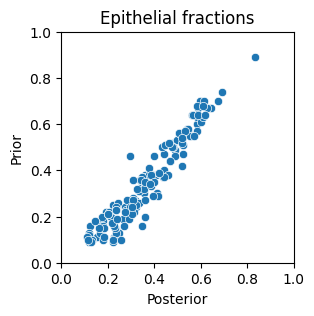

In [47]:
# Lets see if the posterior estimates of the Tumor fractions match the prior expectation
plt.figure(figsize=(3,3))
sns.scatterplot(x=Statescope_simple_model.Fractions.Epithelial, y=Expectation_single.Epithelial)
plt.xlabel('Posterior'); plt.ylabel('Prior')
plt.xlim(0,1); plt.ylim(0,1); plt.title('Epithelial fractions' )
plt.show() # indeed the posterior is highly correlated, but not identical to, the prior

In [17]:
# Run Deconvolution for detailed model with group tumor cell prior
Statescope_detailed_model.Deconvolution(Expectation = Expectation_group)

Grouped prior knowledge is utilised in refining fraction estimates.
all of 755 genes are used for optimization.
Initialization with Support vector regression


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:    1.7s
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed:    2.0s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:    2.4s
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 145 out of 149 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 149 out of 149 | elapsed:    3.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
/n

No feature filtering is done (fsel = 0)


[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 645.7min remaining: 1506.6min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed: 647.3min remaining: 647.3min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed: 647.8min remaining: 277.6min


Deconvolution completed successfully.
Model converged.


[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 648.9min finished


### Statescope Refinement

The next step in the Statescope analysis is the Refinement analysis. In this step, all genes available in the signature are used to performed an additional optimization of the deconvolution. This step is introduced to capture more refined inter-sample variation in the gene expression profiles and is performed for each gene in parralell. The duration of this step decreases with more cores (or less genes) allocated to Statescope (in the intialize step).
If only interested in a particular set of genes, a list of genes can be supplied to the 'GeneList' parameter

In [4]:
%%capture
Statescope_simple_model.Refinement()

/net/beegfs/scratch/jjansen4/miniconda3/envs/Statescope/lib/python3.10/site-packages/BLADE_Deconvolution/BLADE.py:1943: Warning: No optimization is not done yet
  obj.Check_health()
/net/beegfs/scratch/jjansen4/miniconda3/envs/Statescope/lib/python3.10/site-packages/BLADE_Deconvolution/BLADE.py:1943: Warning: No optimization is not done yet
  obj.Check_health()
/net/beegfs/scratch/jjansen4/miniconda3/envs/Statescope/lib/python3.10/site-packages/BLADE_Deconvolution/BLADE.py:1943: Warning: No optimization is not done yet
  obj.Check_health()
/net/beegfs/scratch/jjansen4/miniconda3/envs/Statescope/lib/python3.10/site-packages/BLADE_Deconvolution/BLADE.py:1943: Warning: No optimization is not done yet
  obj.Check_health()
/net/beegfs/scratch/jjansen4/miniconda3/envs/Statescope/lib/python3.10/site-packages/BLADE_Deconvolution/BLADE.py:1943: Warning: No optimization is not done yet
  obj.Check_health()
/net/beegfs/scratch/jjansen4/miniconda3/envs/Statescope/lib/python3.10/site-packages/BLADE

### Statescope State Discovery

The final step in the Statescope analysis is the State Discovery. In this step, the refined cell type-specific gene expression profiles are weighted and subjected to unsupervised clustering analysis using convex-NMF. The output of this module is the StateScores (Sample x K) and StateLoadings (Gene x K) for each cell type. By default, state discovery is performed for each cell type and the number of k is automatically selected based on an heuristic approach.

In [3]:
%%capture
Statescope_simple_model.StateDiscovery()

#### Evaluate State Discovery: K parameter
It is important to evaluate whether the automatically chosen values for k are sensible.
We will create the Cophentic coefficient plot to evaluate the stability of the clustering for the different values of K. As a general rule of thumb, the value of k before the cohpenetic coefficient starts decreasing is the optimal one. It is important to consider that this behaviour can exist at different values of k (multi-modal shape of the plot), and that this approach is less reliable with small sample sizes.

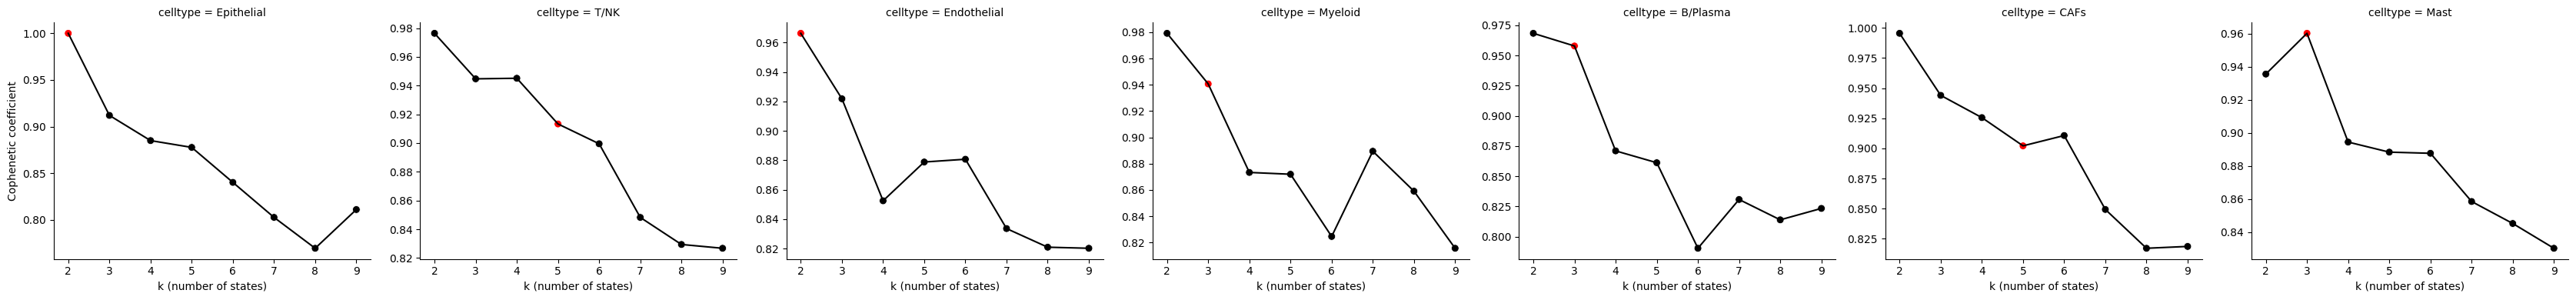

In [5]:
scope.Plot_CopheneticCoefficients(Statescope_simple_model)

The red dot indicates the value of K chosen as the optimal model. For the Eptihelial cell type, three states were chosen. For some cell types, the model chosen seems suboptimal, presumably due to the parameters and relatively low sample size. Values for K can be manually adjusted as performed below.

Performing cNMF State Discovery for Epithelial
The selected value for K is 3
Running final cNMF (100 iterations) with K=3


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   50.2s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  2.2min
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:  2.9min
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:  4.0min
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:  4.6min
[Parallel(n_jobs=10)]: Done  92 out of 100 | elapsed:  5.4min remaining:   28.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  5.7min finished


Performing cNMF State Discovery for T/NK
The selected value for K is 4
Running final cNMF (100 iterations) with K=4


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   34.5s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   56.3s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:  2.2min
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:  4.1min
[Parallel(n_jobs=10)]: Done  92 out of 100 | elapsed:  4.7min remaining:   24.5s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  5.0min finished


StateDiscovery completed successfully.


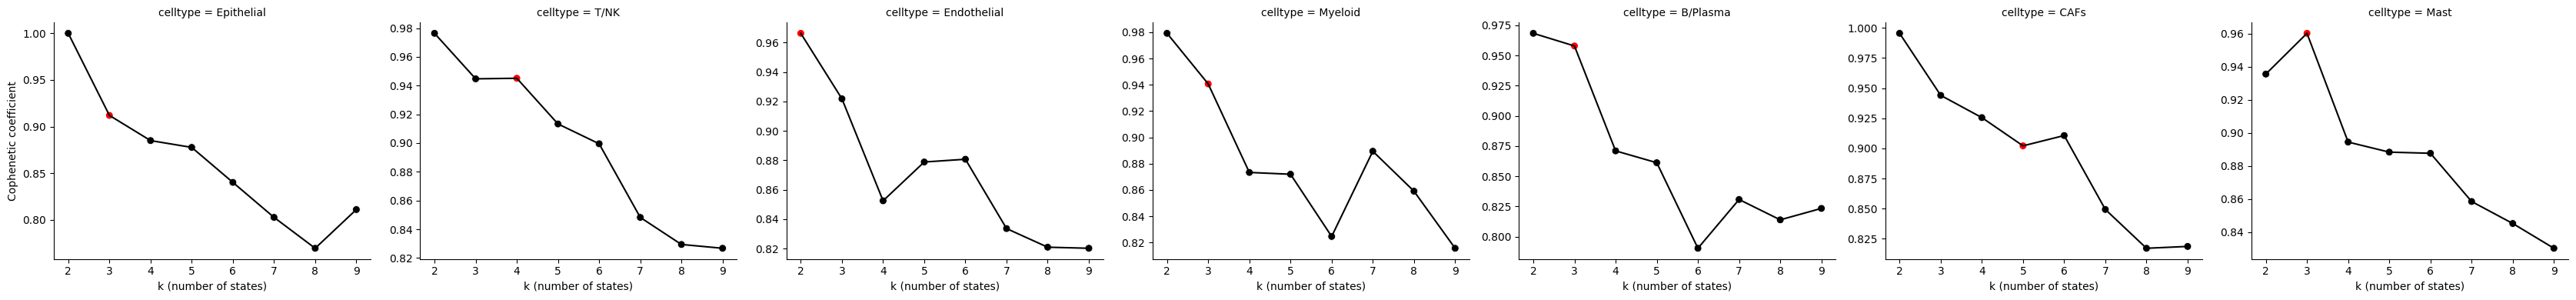

In [8]:
# Example of manually setting K for some cell types
Statescope_simple_model.StateDiscovery(K={'Epithelial': 3,'T/NK': 4})
scope.Plot_CopheneticCoefficients(Statescope_simple_model)

### PDAC intratumor heterogeneity
In this notebook we will investigate whether the Epithelial states detected by the simple model correspond to the well defined Basal/Classical subtypes in a completely unsupervised manner. We will relate the findings of the simple model back to see if they correspond to the findings of the detailed model, in which additional prior knowledge (i.e. more supervised) was available. 

We will inspect:
1. whether the 'Eptithelial' state loadings correspond to well established Classical and Basal markers in literature
2. whether 'Epithelial' state scores correspond to the Basal/Classical fractions of the detailed model
3. whether 'Epithelial' states retrieved in scRNAseq profiles (StateRetrieval) correspond to Classic/Basal cells

#### Statescope results and plotting functions
All results of the Statescope analysis are saved within the Statescope model (for example Statescope.Fractions, Statescope.GEX, Statescope.StateScores, Statescope.StateLoadings). In addition, we provide several functions for standard visualization of the results.



#### 1. Investigate whether the 'Eptithelial' state loadings correspond to well established Classical and Basal markers in literature
Here we will inspect the 3 Epithelial states discovered by Statescope by investigating the top loadings. Based on the single-cell analysis of Raghavan et al (2021, Cell), the top 5 markers associated with the Classical subtype (scBasal state) are KRT6A, S100A2, KRT13, KRT17, LY6D and the top 5 markers associated with the basal subtype (scClassical state) are LGALS4, CTSE, TFF1, AGR2, TSPAN8.

In [4]:
# Inspect top 5 loadings of each Epithelial state
for i in range(len(Statescope_simple_model.StateLoadings['Epithelial'].columns)):
    print(f'Top 5 Epithelial State {i+1} markers: ',Statescope_simple_model.StateLoadings['Epithelial'].sort_values(f'Epithelial_{i}',ascending=False).head(5).index)

Top 5 Epithelial State 1 markers:  Index(['PNLIP', 'CPA1', 'CPB1', 'PRSS1', 'PRSS2'], dtype='object')
Top 5 Epithelial State 2 markers:  Index(['KRT17', 'S100A2', 'TGM2', 'KRT6A', 'ANXA1'], dtype='object')
Top 5 Epithelial State 3 markers:  Index(['TFF1', 'REG4', 'CLDN18', 'CEACAM5', 'MUC5AC'], dtype='object')


1. The top markers of State 1 seem associated with exocrine/acinar cells
2. The top markers of State 2 include keratin genes, just like the scBasal State.
3. The top marker of State 3 is the same as the scClassical State


#### 2. Investigate whether 'Epithelial' state scores correspond to the Basal/Classical fractions of the detailed model

/tmp/ipykernel_14627/676955440.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


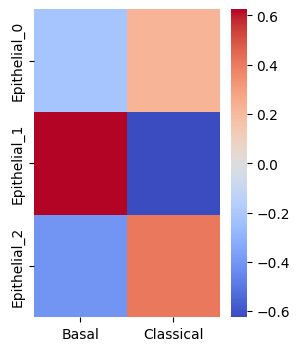

In [7]:
# We calculate the correlation between Basal/Classical fractions estimated by the detailed model and the Epithelial state scores from the simple model
Corr_matrix = pd.concat([Statescope_detailed_model.Fractions[['Classical','Basal']].apply(lambda x: x / sum(x), axis = 1), Statescope_simple_model.StateScores['Epithelial']], axis = 1).corr()
fig, ax = plt.subplots(figsize=(3, 4))
sns.heatmap(Corr_matrix.loc[Statescope_simple_model.StateScores['Epithelial'].columns,['Basal','Classical']], cmap = 'coolwarm')
fig.show()

Epithelial state 1 and 3 scores are correlated with the Classical fractions of the detailed model.
Epithlial state 2 scores are correlated with the basal fractions in the detailed model.

#### 3. Investigate whether 'Epithelial' states retrieved in scRNAseq profiles (StateRetrieval) correspond to Classic/Basal cells
Here we will make use of the natural property of cNMF to retrieve cell state scores in new cell type-specific gene expression data (scRNAseq) using an existing state loadings matrix. Here we will uncover the intratumor heterogeneity by selecting one PDAC sample in the scRNAseq dataset with both basal and classical cells.

In [9]:
scRNAseq_dataset.obs

,major_celltype,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,subtype,classical,basal,intermediate,batch
0171-8-13-20-T:AAACCCACAACCCTAA-0,Epithelial,4702,15284.941406,709.361206,4.640915,Classical,1.070657,0.194597,0.098124,0
0171-8-13-20-T:AAACCCAGTCAAACGG-0,Epithelial,6491,27863.234375,1293.115356,4.640938,Classical,1.050891,0.209696,0.282326,0
0171-8-13-20-T:AAACGAAAGCAAATGT-0,Epithelial,6239,30390.886719,3224.069336,10.608671,Classical,0.674433,0.264121,0.082265,0
0171-8-13-20-T:AAACGAATCTGTCGCT-0,Epithelial,3451,11408.622070,105.957329,0.928748,Classical,0.586770,0.301722,0.235741,0
0171-8-13-20-T:AAACGCTCATGACAGG-0,Epithelial,1247,1984.657104,2.507676,0.126353,Classical,0.660913,0.284064,0.631576,0
...,...,...,...,...,...,...,...,...,...,...
Nov-6115-d0:TTTGCGCTCCCATTTA-1,Myeloid,1659,3623.447021,43.631046,1.204131,Myeloid,NaN,NaN,NaN,1
Nov-6115-d0:TTTGGTTTCCCTTGCA-1,Myeloid,2791,9542.416016,48.275646,0.505906,Myeloid,NaN,NaN,NaN,1
Nov-6115-d0:TTTGGTTTCTCAAACG-1,B/Plasma,2121,14648.389648,122.252419,0.834579,B/Plasma,NaN,NaN,NaN,1
Nov-6115-d0:TTTGTCAAGAGACTAT-1,B/Plasma,873,1576.427856,23.212360,1.472466,B/Plasma,NaN,NaN,NaN,1


Lets select the cells of one tumor for state retrieval

/tmp/ipykernel_14627/1792328223.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


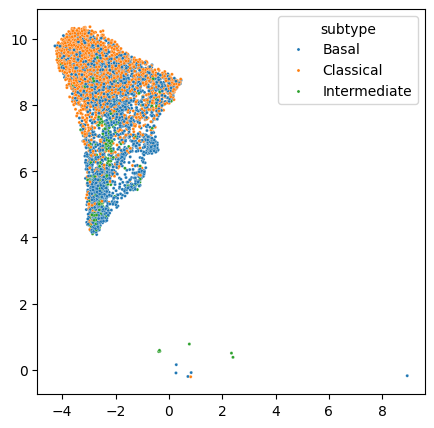

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
scRNAseq_dataset.obs['patient'] = [x.split(':')[0] for x in scRNAseq_dataset.obs.index]
scRNAseq_subset = scRNAseq_dataset[((scRNAseq_dataset.obs.patient == 'Nov-6115-d0') & (scRNAseq_dataset.obs.major_celltype == 'Epithelial'))]
sns.scatterplot(ax=ax, x=scRNAseq_subset.obsm['X_umap'][:,0], y=scRNAseq_subset.obsm['X_umap'][:,1], hue = scRNAseq_subset.obs.subtype, s=5)
fig.show()

#### State Retrieval
We will retrieve the Epithelial states detected from the bulk samples in single Epithelial cell profiles from one tumor

In [11]:
GEX = pd.DataFrame(scRNAseq_subset.X.toarray(), index = scRNAseq_subset.obs.index, columns = scRNAseq_subset.var.index)
StateScores_scRNAseq = scope.StateRetrieval(GEX = GEX, Omega = Statescope_simple_model.scVar[['scVar_Epithelial']].rename(columns = {'scVar_Epithelial':'Epithelial'}), celltype='Epithelial', StateLoadings = Statescope_simple_model.StateLoadings['Epithelial'])
StateScores_scRNAseq

,0,1,2
0,0.126533,0.128840,0.744626
1,0.098560,0.073441,0.827999
2,0.171815,0.345959,0.482226
3,0.156156,0.218001,0.625843
4,0.165299,0.637194,0.197507
...,...,...,...
5723,0.148574,0.661084,0.190342
5724,0.111480,0.797876,0.090644
5725,0.092619,0.850080,0.057301
5726,0.084945,0.051969,0.863086


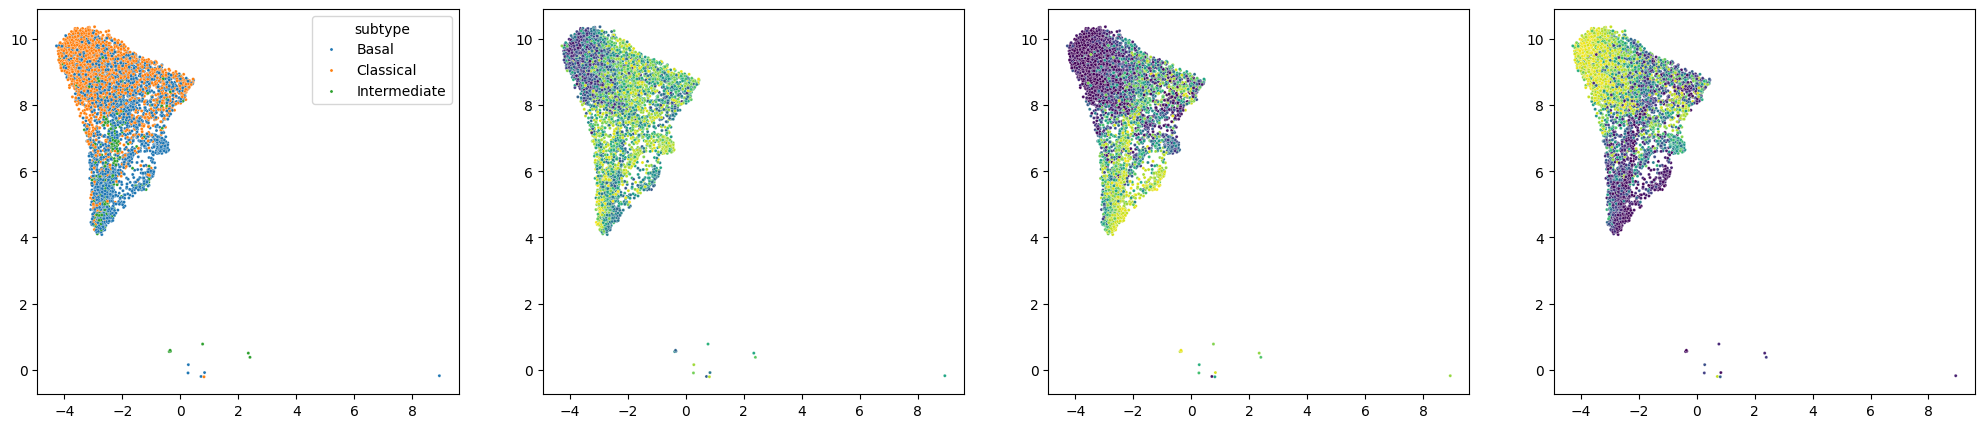

In [14]:
fig, axes = plt.subplots(1,len(StateScores_scRNAseq.columns)+1,figsize=(25, 5))
axes = axes.ravel()
sns.scatterplot(ax=axes[0], x=scRNAseq_subset.obsm['X_umap'][:,0], y=scRNAseq_subset.obsm['X_umap'][:,1], hue = scRNAseq_subset.obs.subtype, s=5)
for i in range(len(StateScores_scRNAseq.columns)):
    sns.scatterplot(ax=axes[i+1], x=scRNAseq_subset.obsm['X_umap'][:,0], y=scRNAseq_subset.obsm['X_umap'][:,1], hue = StateScores_scRNAseq[i], s=5,palette='viridis', legend = False)


Here we observe an enrichment of State 3 scores in the classical cells and an enrichment of State 2 scores in the basal cells.

Taken together, Statescope identified Epithelial state 2 as Basal and Epithelial state 3 as Classical.